# homework 1

#### Dominik Pegler  
#### 2022-06-05

Due: June 05 2022

## Prepare data

In [1]:
library(data.table)
library(ggplot2)

filelist = list.files(pattern = ".*.txt")
datalist = lapply(filelist, function(x)read.table(x, header=T)) 
df <- do.call("rbind", datalist)
setDT(df) # Convert data.frame to data.table

                  df$sbj <- factor(df$sbj)
df$answerCorrect <- factor(df$answerCorrect,levels=c(0,1,99),labels=c("incorrect","correct","timeout"))

# eliminate subject 12
df <- df[df$sbj != "12",]
df <- df[df$answerCorrect=="correct" & df$reactionTime<=1 & df$reactionTime >= 0.15,]

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


**Simulate the design and data of your experiment (factors and number of trials per experimental condition) 1000 times to estimate the statistical power under the following conditions.**

1. Determine the statistical power of your experiment to find a validity effect of 20 ms.
2. How small can the validity effect be to achieve a test power of 80%.
3. How small can the validity effect be to achieve a test power of 90%.
4. Finds the minimum number of participants needed to find an effect of 20 ms with a test power of 90%. 
5. Finds the average minimum number of valid trials per cue condition needed to find an effect of 20 ms with a test power of 90%. To do this, you can adjust the trialChangeFactor variable to change the number of trials per participant. The variable is a multiplier, so a trialChangeFactor of 1.5 means one and a half times as many trials per participant as in your experiment, 0.5 means half as many trials, etc. The ratio of valid and invalid trials remains the same. You can calculate the average number of valid runs per person by determining this in your data set and multiplying it by the trialChangeFactor or by determining it from the simulated data.

Create variables `RTnormalized` and `RTnormalized_real`

In [55]:
mean_rt

condition,meanRT
real,0.6006951
normalized,0.6006951
effect,0.5806951


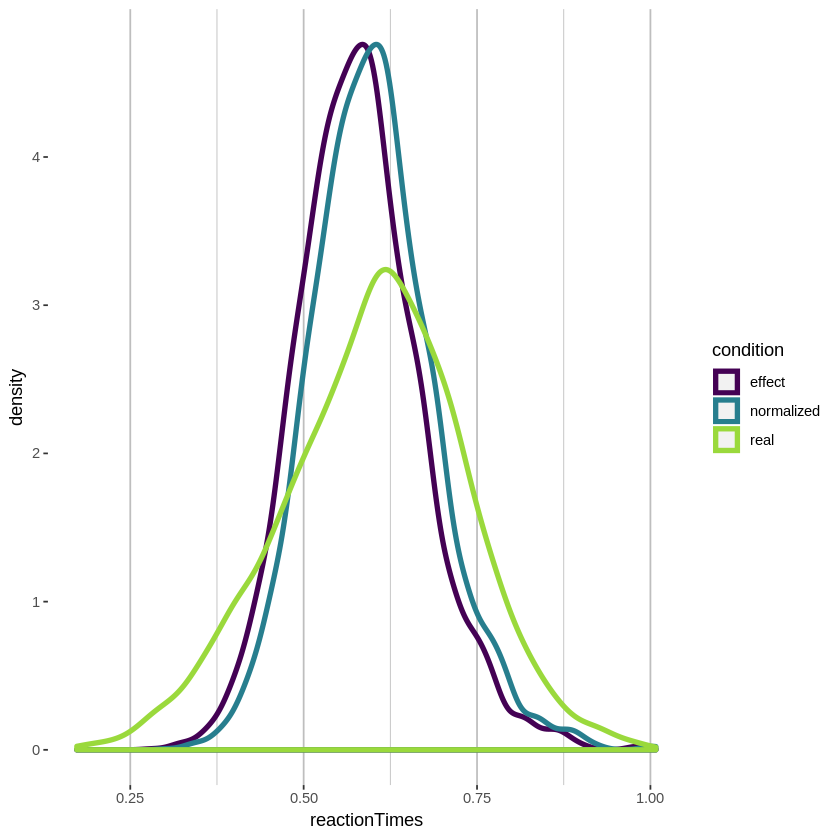

In [8]:
df$condition <- paste(df$targetValidity, df$cueSize, sep = "_")

# Variablen initiieren
vpn <- NULL
i <- NULL
j <- NULL
df$RTnormalized <- 0 

for (i in 1:length(unique(df$sbj))) { # Loop über alle Personen
  vpn_temp <- unique(df$sbj)[i] 
  for (j in 1:length(unique(df$condition))) { # Loop über alle Bedingungen pro Person (deshalb genestet [Loop im Loop])
    condition_temp <- unique(df$condition)[j] 
    meanRT_temp <- mean(df[condition == condition_temp & sbj == vpn_temp]$reactionTime) # mittlere Reaktionszeit für diese Bedingung ermitteln
    df[condition == condition_temp & sbj == vpn_temp]$RTnormalized <- 
      df[condition == condition_temp & sbj == vpn_temp]$reactionTime - meanRT_temp # mittlere Reaktionszeit von den Reaktionszeiten abziehen
  }
}

# Um die Reaktionszeiten wieder realistischer bzwl. leichter interpretierbar zu machen, addieren wir den Mittelwert aller Reaktionzeiten. Die Form der Verteilung bleibt davon unbeeinflusst.
df$RTnormalized_real <- df$RTnormalized + mean(df$reactionTime)

# plot distributions
effect <- 0.02 # minimal relevant effect size to simulate
condition <- rep(c("real", "normalized", "effect"),
                 each = length(df$RTnormalized_real))
reactionTimes <- c(df$reactionTime,
                   df$RTnormalized_real,
                   df$RTnormalized_real - effect)

rt_distributions <- data.table(condition = condition, reactionTimes = reactionTimes)

mean_rt <- rt_distributions[, .(meanRT = mean(reactionTimes)), by = .(condition)]

ggplot(rt_distributions, aes(reactionTimes, color = condition)) +
  geom_density(size = 1.5) +
  scale_color_viridis_d(end = 0.85) +
  theme(panel.background = element_blank(),
        panel.grid = element_line(color = "gray"),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.y = element_blank())

**Create template datatable**

In [14]:
# copy from the real data used for the analysis
dt_template <- copy(df[, c("cueSize", "targetValidity", "sbj")])

# remove non-existing levels
dt_template$sbj <- factor(dt_template$sbj, levels = (unique(dt_template$sbj)))

# change sbj to 1:end
levels(dt_template$sbj) <- c(1:length(unique(dt_template$sbj)))

---

## 1. Determine the statistical power of your experiment to find a validity effect of 20 ms.

**Simulate reaction times**

In [ ]:
Nsim <- 1000 # Number of simulations
effect <- 0.02 # 20 ms validity effect (smallest relevant effect size)
sampleSize <- length(unique(dt_template$sbj)) # sample size of data
simSampleSize <- sampleSize # sample size for simulation (can be changed!)
trialChangeFactor <- 1 # change factor for trial number to increase or decrease trial number
simList <- vector(mode = "list", length = Nsim)
j <- NULL
i <-  NULL
for (j in 1:Nsim) {
  start.time <- Sys.time()
  simData <- copy(dt_template)
  if (simSampleSize < sampleSize) {
    randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize)
    simData <- simData[simData$sbj %in% randomSbj,]
    levels(simData$sbj)[levels(simData$sbj) %in% randomSbj] <- c(1:simSampleSize)
    } else if (simSampleSize > sampleSize) {
      sampleSizeIncrease <- simSampleSize - sampleSize
      if (sampleSizeIncrease <= sampleSize) {
        randomSbj <- sample(1:length(unique(simData$sbj)), sampleSizeIncrease)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <- c((sampleSize+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simData, simDataAddition)
      } else if (sampleSizeIncrease > sampleSize) {
        simRepetition <- floor(simSampleSize / sampleSize)
        simDataBase <- simData[rep(seq_len(nrow(simData)), times = simRepetition), ]
        simDataBase$repetition <- rep(1:simRepetition, each = nrow(simData))
        simDataBase$sbj_new <- as.numeric(simDataBase$sbj)
        simDataBase$sbj_new <- simDataBase$sbj_new + sampleSize * (simDataBase$repetition-1)
        simDataBase$sbj <- as.factor(simDataBase$sbj_new)
        simDataBase$repetition <- NULL
        simDataBase$sbj_new <- NULL
        randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize %% sampleSize)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <-
        c((length(unique(simDataBase$sbj))+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simDataBase, simDataAddition)
      }
    }

  if (trialChangeFactor < 1) {
    simData <- simData[sample(1:nrow(simData), round(nrow(simData) * trialChangeFactor))]
  } else if (trialChangeFactor > 1) {
    simData <- rbind(simData[rep(seq_len(nrow(simData)), times = floor(trialChangeFactor)), ],
                     simData[sample(1:nrow(simData), round(nrow(simData) * (trialChangeFactor-floor(trialChangeFactor))))])
  }

  for (i in 1:simSampleSize) {
    # simulates random interindividual variance
    individualRTvariance <-  rnorm(1, mean = 0, sd = 0.05)
    RT_var_sd <- 0.015
    RT_var1 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var2 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var3 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var4 <- rnorm(1, mean = 0, sd = RT_var_sd)

    # simulate reaction times per condition
    RT_1 <- sample(df$RTnormalized_real - effect + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueSize == "small"]),
                   replace = TRUE) + RT_var1
    RT_2 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueSize == "big"]),
                   replace = TRUE) + RT_var2
    RT_3 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueSize == "small"]),
                   replace = TRUE) + RT_var3
    RT_4 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueSize == "big"]),
                   replace = TRUE) + RT_var4

    # Zuordnung der simulierten Reaktionszeiten zu den Faktorkombinationen
    simData[sbj == i & targetValidity == "valid" & cueSize == "small", reactionTime := RT_1]
    simData[sbj == i & targetValidity == "valid" & cueSize == "big", reactionTime := RT_2]
    simData[sbj == i & targetValidity == "invalid" & cueSize == "small", reactionTime := RT_3]
    simData[sbj == i & targetValidity == "invalid" & cueSize == "big", reactionTime := RT_4]
  }

  simData[, simNo := j] # ergänzt neue Variable mit der Nummer der Simulation
  simList[[j]] <- copy(simData) # speichert das fertige simulierte Datenframe in die Liste mit den Simulationen
  end.time <- Sys.time() # End-Zeit der Simulation eines Datensatzes
  time.taken <- end.time - start.time # Dauer der Simulation eines Datensatzes
  print(paste("Progress: ", j, "/", Nsim, " (Duration: ", time.taken, " sec)", sep = ""))
}

simData <- rbindlist(simList)
head(simData) # erste 6 Zeilen
tail(simData) # letzte 6 Zeilen

# Zuletzt vergleichen wir noch die Standardabweichungen der Reaktionzeiten in den Bedingungen der realen und simulierten Daten
data_trimmed_means_sbj <- df[, .(meanRT = mean(reactionTime)),
                                       by = .(sbj, cueSize, targetValidity)]

data_trimmed_sd <- data_trimmed_means_sbj[, .(SD = sd(meanRT)), by = .(targetValidity, cueSize)]

simData_trimmed_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                                     by = .(sbj, targetValidity, cueSize, simNo)]

simData_trimmed_sd_sim <- simData_trimmed_means_sbj[, .(SD = sd(meanRT)),
                                                    by = .(targetValidity, cueSize, simNo)]

simData_trimmed_sd <- simData_trimmed_sd_sim[, .(SD = mean(SD)),
                                             by = .(targetValidity, cueSize)]

# Berechnung des Validitätseffeks
simData_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                             by = .(simNo, targetValidity, cueSize, sbj)]

simValidityEffect <- simData_means_sbj[, .(validityEffect = meanRT[targetValidity == "invalid"] -
                                                            meanRT[targetValidity == "valid"]),
                                       by = .(cueSize, sbj, simNo)]

# Ergebnisse berechnen
simValidityEffect_results <- simValidityEffect[,
                                 .(meanValidityEffect = t.test(validityEffect, mu = 0)$estimate,
                                   p.value = t.test(validityEffect, mu = 0)$p.value,
                                   t.stat = t.test(validityEffect, mu = 0)$statistic),
                                 by = .(simNo, cueSize)]

sigNiveau <- 0.05 # Signifikanzniveau definieren

powerResults <- simValidityEffect_results[t.stat > 0 & p.value < sigNiveau,
                                          .(EffectFound = .N,
                                            Nsim = max(simValidityEffect_results$simNo),
                                            testPower = .N / max(simValidityEffect_results$simNo)),
                                          by = .(cueSize)]

In [80]:
powerResults

cueSize,EffectFound,Nsim,testPower
small,750,1000,0.750
big,25,1000,0.025


## 2. How small can the validity effect be to achieve a test power of 80%

In [ ]:
Nsim <- 1000 # Number of simulations
effect <- 0.0217 # 20 ms validity effect (smallest relevant effect size)
sampleSize <- length(unique(dt_template$sbj)) # sample size of data
simSampleSize <- sampleSize # sample size for simulation (can be changed!)
trialChangeFactor <- 1 # change factor for trial number to increase or decrease trial number
simList <- vector(mode = "list", length = Nsim)
j <- NULL
i <-  NULL
for (j in 1:Nsim) {
  start.time <- Sys.time()
  simData <- copy(dt_template)
  if (simSampleSize < sampleSize) {
    randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize)
    simData <- simData[simData$sbj %in% randomSbj,]
    levels(simData$sbj)[levels(simData$sbj) %in% randomSbj] <- c(1:simSampleSize)
    } else if (simSampleSize > sampleSize) {
      sampleSizeIncrease <- simSampleSize - sampleSize
      if (sampleSizeIncrease <= sampleSize) {
        randomSbj <- sample(1:length(unique(simData$sbj)), sampleSizeIncrease)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <- c((sampleSize+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simData, simDataAddition)
      } else if (sampleSizeIncrease > sampleSize) {
        simRepetition <- floor(simSampleSize / sampleSize)
        simDataBase <- simData[rep(seq_len(nrow(simData)), times = simRepetition), ]
        simDataBase$repetition <- rep(1:simRepetition, each = nrow(simData))
        simDataBase$sbj_new <- as.numeric(simDataBase$sbj)
        simDataBase$sbj_new <- simDataBase$sbj_new + sampleSize * (simDataBase$repetition-1)
        simDataBase$sbj <- as.factor(simDataBase$sbj_new)
        simDataBase$repetition <- NULL
        simDataBase$sbj_new <- NULL
        randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize %% sampleSize)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <-
        c((length(unique(simDataBase$sbj))+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simDataBase, simDataAddition)
      }
    }

  if (trialChangeFactor < 1) {
    simData <- simData[sample(1:nrow(simData), round(nrow(simData) * trialChangeFactor))]
  } else if (trialChangeFactor > 1) {
    simData <- rbind(simData[rep(seq_len(nrow(simData)), times = floor(trialChangeFactor)), ],
                     simData[sample(1:nrow(simData), round(nrow(simData) * (trialChangeFactor-floor(trialChangeFactor))))])
  }

  for (i in 1:simSampleSize) {
    # simulates random interindividual variance
    individualRTvariance <-  rnorm(1, mean = 0, sd = 0.05)
    RT_var_sd <- 0.015
    RT_var1 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var2 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var3 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var4 <- rnorm(1, mean = 0, sd = RT_var_sd)

    # simulate reaction times per condition
    RT_1 <- sample(df$RTnormalized_real - effect + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueSize == "small"]),
                   replace = TRUE) + RT_var1
    RT_2 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueSize == "big"]),
                   replace = TRUE) + RT_var2
    RT_3 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueSize == "small"]),
                   replace = TRUE) + RT_var3
    RT_4 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueSize == "big"]),
                   replace = TRUE) + RT_var4

    # Zuordnung der simulierten Reaktionszeiten zu den Faktorkombinationen
    simData[sbj == i & targetValidity == "valid" & cueSize == "small", reactionTime := RT_1]
    simData[sbj == i & targetValidity == "valid" & cueSize == "big", reactionTime := RT_2]
    simData[sbj == i & targetValidity == "invalid" & cueSize == "small", reactionTime := RT_3]
    simData[sbj == i & targetValidity == "invalid" & cueSize == "big", reactionTime := RT_4]
  }

  simData[, simNo := j] # ergänzt neue Variable mit der Nummer der Simulation
  simList[[j]] <- copy(simData) # speichert das fertige simulierte Datenframe in die Liste mit den Simulationen
  end.time <- Sys.time() # End-Zeit der Simulation eines Datensatzes
  time.taken <- end.time - start.time # Dauer der Simulation eines Datensatzes
}

simData <- rbindlist(simList)

# Zuletzt vergleichen wir noch die Standardabweichungen der Reaktionzeiten in den Bedingungen der realen und simulierten Daten
data_trimmed_means_sbj <- df[, .(meanRT = mean(reactionTime)),
                                       by = .(sbj, cueSize, targetValidity)]

data_trimmed_sd <- data_trimmed_means_sbj[, .(SD = sd(meanRT)), by = .(targetValidity, cueSize)]

simData_trimmed_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                                     by = .(sbj, targetValidity, cueSize, simNo)]

simData_trimmed_sd_sim <- simData_trimmed_means_sbj[, .(SD = sd(meanRT)),
                                                    by = .(targetValidity, cueSize, simNo)]

simData_trimmed_sd <- simData_trimmed_sd_sim[, .(SD = mean(SD)),
                                             by = .(targetValidity, cueSize)]

# Berechnung des Validitätseffeks
simData_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                             by = .(simNo, targetValidity, cueSize, sbj)]

simValidityEffect <- simData_means_sbj[, .(validityEffect = meanRT[targetValidity == "invalid"] -
                                                            meanRT[targetValidity == "valid"]),
                                       by = .(cueSize, sbj, simNo)]

# Ergebnisse berechnen
simValidityEffect_results <- simValidityEffect[,
                                 .(meanValidityEffect = t.test(validityEffect, mu = 0)$estimate,
                                   p.value = t.test(validityEffect, mu = 0)$p.value,
                                   t.stat = t.test(validityEffect, mu = 0)$statistic),
                                 by = .(simNo, cueSize)]

sigNiveau <- 0.05 # Signifikanzniveau definieren

powerResults <- simValidityEffect_results[t.stat > 0 & p.value < sigNiveau,
                                          .(EffectFound = .N,
                                            Nsim = max(simValidityEffect_results$simNo),
                                            testPower = .N / max(simValidityEffect_results$simNo)),
                                          by = .(cueSize)]

In [109]:
powerResults

cueSize,EffectFound,Nsim,testPower
small,835,1000,0.835
big,20,1000,0.020


Around 21.7 ms

## 3. How small can the validity effect be to achieve a test power of 90%

In [123]:
Nsim <- 1000 # Number of simulations
effect <- 0.024 # 20 ms validity effect (smallest relevant effect size)
sampleSize <- length(unique(dt_template$sbj)) # sample size of data
simSampleSize <- sampleSize # sample size for simulation (can be changed!)
trialChangeFactor <- 1 # change factor for trial number to increase or decrease trial number
simList <- vector(mode = "list", length = Nsim)
j <- NULL
i <-  NULL
for (j in 1:Nsim) {
  start.time <- Sys.time()
  simData <- copy(dt_template)
  if (simSampleSize < sampleSize) {
    randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize)
    simData <- simData[simData$sbj %in% randomSbj,]
    levels(simData$sbj)[levels(simData$sbj) %in% randomSbj] <- c(1:simSampleSize)
    } else if (simSampleSize > sampleSize) {
      sampleSizeIncrease <- simSampleSize - sampleSize
      if (sampleSizeIncrease <= sampleSize) {
        randomSbj <- sample(1:length(unique(simData$sbj)), sampleSizeIncrease)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <- c((sampleSize+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simData, simDataAddition)
      } else if (sampleSizeIncrease > sampleSize) {
        simRepetition <- floor(simSampleSize / sampleSize)
        simDataBase <- simData[rep(seq_len(nrow(simData)), times = simRepetition), ]
        simDataBase$repetition <- rep(1:simRepetition, each = nrow(simData))
        simDataBase$sbj_new <- as.numeric(simDataBase$sbj)
        simDataBase$sbj_new <- simDataBase$sbj_new + sampleSize * (simDataBase$repetition-1)
        simDataBase$sbj <- as.factor(simDataBase$sbj_new)
        simDataBase$repetition <- NULL
        simDataBase$sbj_new <- NULL
        randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize %% sampleSize)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <-
        c((length(unique(simDataBase$sbj))+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simDataBase, simDataAddition)
      }
    }

  if (trialChangeFactor < 1) {
    simData <- simData[sample(1:nrow(simData), round(nrow(simData) * trialChangeFactor))]
  } else if (trialChangeFactor > 1) {
    simData <- rbind(simData[rep(seq_len(nrow(simData)), times = floor(trialChangeFactor)), ],
                     simData[sample(1:nrow(simData), round(nrow(simData) * (trialChangeFactor-floor(trialChangeFactor))))])
  }

  for (i in 1:simSampleSize) {
    # simulates random interindividual variance
    individualRTvariance <-  rnorm(1, mean = 0, sd = 0.05)
    RT_var_sd <- 0.015
    RT_var1 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var2 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var3 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var4 <- rnorm(1, mean = 0, sd = RT_var_sd)

    # simulate reaction times per condition
    RT_1 <- sample(df$RTnormalized_real - effect + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueSize == "small"]),
                   replace = TRUE) + RT_var1
    RT_2 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueSize == "big"]),
                   replace = TRUE) + RT_var2
    RT_3 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueSize == "small"]),
                   replace = TRUE) + RT_var3
    RT_4 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueSize == "big"]),
                   replace = TRUE) + RT_var4

    # Zuordnung der simulierten Reaktionszeiten zu den Faktorkombinationen
    simData[sbj == i & targetValidity == "valid" & cueSize == "small", reactionTime := RT_1]
    simData[sbj == i & targetValidity == "valid" & cueSize == "big", reactionTime := RT_2]
    simData[sbj == i & targetValidity == "invalid" & cueSize == "small", reactionTime := RT_3]
    simData[sbj == i & targetValidity == "invalid" & cueSize == "big", reactionTime := RT_4]
  }

  simData[, simNo := j] # ergänzt neue Variable mit der Nummer der Simulation
  simList[[j]] <- copy(simData) # speichert das fertige simulierte Datenframe in die Liste mit den Simulationen
  end.time <- Sys.time() # End-Zeit der Simulation eines Datensatzes
  time.taken <- end.time - start.time # Dauer der Simulation eines Datensatzes
}

simData <- rbindlist(simList)

# Zuletzt vergleichen wir noch die Standardabweichungen der Reaktionzeiten in den Bedingungen der realen und simulierten Daten
data_trimmed_means_sbj <- df[, .(meanRT = mean(reactionTime)),
                                       by = .(sbj, cueSize, targetValidity)]

data_trimmed_sd <- data_trimmed_means_sbj[, .(SD = sd(meanRT)), by = .(targetValidity, cueSize)]

simData_trimmed_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                                     by = .(sbj, targetValidity, cueSize, simNo)]

simData_trimmed_sd_sim <- simData_trimmed_means_sbj[, .(SD = sd(meanRT)),
                                                    by = .(targetValidity, cueSize, simNo)]

simData_trimmed_sd <- simData_trimmed_sd_sim[, .(SD = mean(SD)),
                                             by = .(targetValidity, cueSize)]

# Berechnung des Validitätseffeks
simData_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                             by = .(simNo, targetValidity, cueSize, sbj)]

simValidityEffect <- simData_means_sbj[, .(validityEffect = meanRT[targetValidity == "invalid"] -
                                                            meanRT[targetValidity == "valid"]),
                                       by = .(cueSize, sbj, simNo)]

# Ergebnisse berechnen
simValidityEffect_results <- simValidityEffect[,
                                 .(meanValidityEffect = t.test(validityEffect, mu = 0)$estimate,
                                   p.value = t.test(validityEffect, mu = 0)$p.value,
                                   t.stat = t.test(validityEffect, mu = 0)$statistic),
                                 by = .(simNo, cueSize)]

sigNiveau <- 0.05 # Signifikanzniveau definieren

powerResults <- simValidityEffect_results[t.stat > 0 & p.value < sigNiveau,
                                          .(EffectFound = .N,
                                            Nsim = max(simValidityEffect_results$simNo),
                                            testPower = .N / max(simValidityEffect_results$simNo)),
                                          by = .(cueSize)]

In [124]:
powerResults

cueSize,EffectFound,Nsim,testPower
small,884,1000,0.884
big,22,1000,0.022


Around 25 ms

## 4. Find the minimum number of participants needed to find an effect of 20 ms with a test power of 90%

In [ ]:
Nsim <- 1000 # Number of simulations
effect <- 0.02 # 20 ms validity effect (smallest relevant effect size)
#sampleSize <- length(unique(dt_template$sbj)) # sample size of data
simSampleSize <- 22 # sample size for simulation (can be changed!)
trialChangeFactor <- 1 # change factor for trial number to increase or decrease trial number
simList <- vector(mode = "list", length = Nsim)
j <- NULL
i <-  NULL
for (j in 1:Nsim) {
  start.time <- Sys.time()
  simData <- copy(dt_template)
  if (simSampleSize < sampleSize) {
    randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize)
    simData <- simData[simData$sbj %in% randomSbj,]
    levels(simData$sbj)[levels(simData$sbj) %in% randomSbj] <- c(1:simSampleSize)
    } else if (simSampleSize > sampleSize) {
      sampleSizeIncrease <- simSampleSize - sampleSize
      if (sampleSizeIncrease <= sampleSize) {
        randomSbj <- sample(1:length(unique(simData$sbj)), sampleSizeIncrease)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <- c((sampleSize+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simData, simDataAddition)
      } else if (sampleSizeIncrease > sampleSize) {
        simRepetition <- floor(simSampleSize / sampleSize)
        simDataBase <- simData[rep(seq_len(nrow(simData)), times = simRepetition), ]
        simDataBase$repetition <- rep(1:simRepetition, each = nrow(simData))
        simDataBase$sbj_new <- as.numeric(simDataBase$sbj)
        simDataBase$sbj_new <- simDataBase$sbj_new + sampleSize * (simDataBase$repetition-1)
        simDataBase$sbj <- as.factor(simDataBase$sbj_new)
        simDataBase$repetition <- NULL
        simDataBase$sbj_new <- NULL
        randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize %% sampleSize)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <-
        c((length(unique(simDataBase$sbj))+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simDataBase, simDataAddition)
      }
    }

  if (trialChangeFactor < 1) {
    simData <- simData[sample(1:nrow(simData), round(nrow(simData) * trialChangeFactor))]
  } else if (trialChangeFactor > 1) {
    simData <- rbind(simData[rep(seq_len(nrow(simData)), times = floor(trialChangeFactor)), ],
                     simData[sample(1:nrow(simData), round(nrow(simData) * (trialChangeFactor-floor(trialChangeFactor))))])
  }

  for (i in 1:simSampleSize) {
    # simulates random interindividual variance
    individualRTvariance <-  rnorm(1, mean = 0, sd = 0.05)
    RT_var_sd <- 0.015
    RT_var1 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var2 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var3 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var4 <- rnorm(1, mean = 0, sd = RT_var_sd)

    # simulate reaction times per condition
    RT_1 <- sample(df$RTnormalized_real - effect + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueSize == "small"]),
                   replace = TRUE) + RT_var1
    RT_2 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueSize == "big"]),
                   replace = TRUE) + RT_var2
    RT_3 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueSize == "small"]),
                   replace = TRUE) + RT_var3
    RT_4 <- sample(df$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueSize == "big"]),
                   replace = TRUE) + RT_var4

    # Zuordnung der simulierten Reaktionszeiten zu den Faktorkombinationen
    simData[sbj == i & targetValidity == "valid" & cueSize == "small", reactionTime := RT_1]
    simData[sbj == i & targetValidity == "valid" & cueSize == "big", reactionTime := RT_2]
    simData[sbj == i & targetValidity == "invalid" & cueSize == "small", reactionTime := RT_3]
    simData[sbj == i & targetValidity == "invalid" & cueSize == "big", reactionTime := RT_4]
  }

  simData[, simNo := j] # ergänzt neue Variable mit der Nummer der Simulation
  simList[[j]] <- copy(simData) # speichert das fertige simulierte Datenframe in die Liste mit den Simulationen
  end.time <- Sys.time() # End-Zeit der Simulation eines Datensatzes
  time.taken <- end.time - start.time # Dauer der Simulation eines Datensatzes
}

simData <- rbindlist(simList)

# Zuletzt vergleichen wir noch die Standardabweichungen der Reaktionzeiten in den Bedingungen der realen und simulierten Daten
data_trimmed_means_sbj <- df[, .(meanRT = mean(reactionTime)),
                                       by = .(sbj, cueSize, targetValidity)]

data_trimmed_sd <- data_trimmed_means_sbj[, .(SD = sd(meanRT)), by = .(targetValidity, cueSize)]

simData_trimmed_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                                     by = .(sbj, targetValidity, cueSize, simNo)]

simData_trimmed_sd_sim <- simData_trimmed_means_sbj[, .(SD = sd(meanRT)),
                                                    by = .(targetValidity, cueSize, simNo)]

simData_trimmed_sd <- simData_trimmed_sd_sim[, .(SD = mean(SD)),
                                             by = .(targetValidity, cueSize)]

# Berechnung des Validitätseffeks
simData_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                             by = .(simNo, targetValidity, cueSize, sbj)]

simValidityEffect <- simData_means_sbj[, .(validityEffect = meanRT[targetValidity == "invalid"] -
                                                            meanRT[targetValidity == "valid"]),
                                       by = .(cueSize, sbj, simNo)]

# Ergebnisse berechnen
simValidityEffect_results <- simValidityEffect[,
                                 .(meanValidityEffect = t.test(validityEffect, mu = 0)$estimate,
                                   p.value = t.test(validityEffect, mu = 0)$p.value,
                                   t.stat = t.test(validityEffect, mu = 0)$statistic),
                                 by = .(simNo, cueSize)]

sigNiveau <- 0.05 # Signifikanzniveau definieren

powerResults <- simValidityEffect_results[t.stat > 0 & p.value < sigNiveau,
                                          .(EffectFound = .N,
                                            Nsim = max(simValidityEffect_results$simNo),
                                            testPower = .N / max(simValidityEffect_results$simNo)),
                                          by = .(cueSize)]

In [ ]:
powerResults

22 People

## 5. Find the average minimum number of valid trials per cue ...
... condition needed to find an effect of 20 ms with a test power of 90%. To do this, you can adjust the trialChangeFactor variable to change the number of trials per participant. The variable is a multiplier, so a trialChangeFactor of 1.5 means one and a half times as many trials per participant as in your experiment, 0.5 means half as many trials, etc. The ratio of valid and invalid trials remains the same. You can calculate the average number of valid runs per person by determining this in your data set and multiplying it by the trialChangeFactor or by determining it from the simulated data.



In [ ]:
avg_valid_runs_per_sbj <- 